### **Señas Chapinas: Traductor de LENSEGUA**
#### *Módulo de Procesamiento de Lenguaje Natural*

Stefano Alberto Aragoni Maldonado

-------------------

#### **Análisis Exploratorio de Datos**

En la fase inicial del proyecto, se recopilaron frases en español que utilizaban la gramática de LENSEGUA. Estas frases fueron almacenadas en un archivo CSV junto con sus contrapartes gramaticalmente correctas en español.

Estas frases se utilizarán para fine-tunear un LLM pre-entrenado, con el objetivo de que este modelo pueda asimilar la gramática de LENSEGUA. A través de esto, se espera que pueda interpretar oraciones que utilicen dicha gramática y las escriba correctamente en español.


Con eso dicho, este notebook tiene como objetivo realizar un análisis exploratorio de los datos recopilados. Se buscará entender la distribución de las frases en el dataset, el lengua utilizado, la longitud de las frases, entre otros aspectos.

___

#### *Importar librerías*
Como primer paso, se importan las librerías necesarias para el desarrollo del problema.

In [3]:
# Import libraries and modules
import numpy as np
import pandas as pd
import re
from collections import Counter
from nltk import ngrams
from copy import deepcopy
from tqdm import tqdm

import seaborn as sns
import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix
from prettytable import PrettyTable

___

#### *Cargar el dataset*

Luego, se carga el dataset que contiene las frases en español y su contraparte en LENSEGUA.

In [7]:
data = pd.read_csv("../../dataset/raw/dataset.csv")                                                # Load the dataset

data["LENSEGUA"] = data["LENSEGUA"].apply(lambda x: re.sub(r'[^\w\s]', '', x.lower()))      # Remove punctuation and convert to lowercase
data["ESPAÑOL"] = data["ESPAÑOL"].apply(lambda x: re.sub(r'[^\w\s]', '', x.lower()))        # Remove punctuation and convert to lowercase

data.head(15)                                                                               # Display the first 15 rows of the dataset

,LENSEGUA,ESPAÑOL
0,abuela 70 años tener,mi abuela tiene 70 años
1,abuelo 70 años tener,mi abuelo tiene 70 años
2,abuelo enfermo mucho,mi abuelo está muy enfermo
3,aeropuerto dónde pregunta,dónde está el aeropuerto
4,aeropuerto yo ir cuál pregunta,a cuál aeropuerto tengo que ir
5,ahora tu libro leer cuál pregunta,cuál libro estás leyendo ahora
6,alegre señas aprender y hacer,es alegre aprender y hacer señas
7,amiga desaparecer tu información compartir,mi amiga desapareció comparte la información
8,anillo precio cuánto pregunta,cuánto cuesta el anillo
9,año pasado ella carro aprender,ella aprendió a manejar el año pasado


___

#### *Longitud de las frases*

Posteriormente se busca comprender la diferencia entre la longitud de las frases en español y en LENSEGUA.

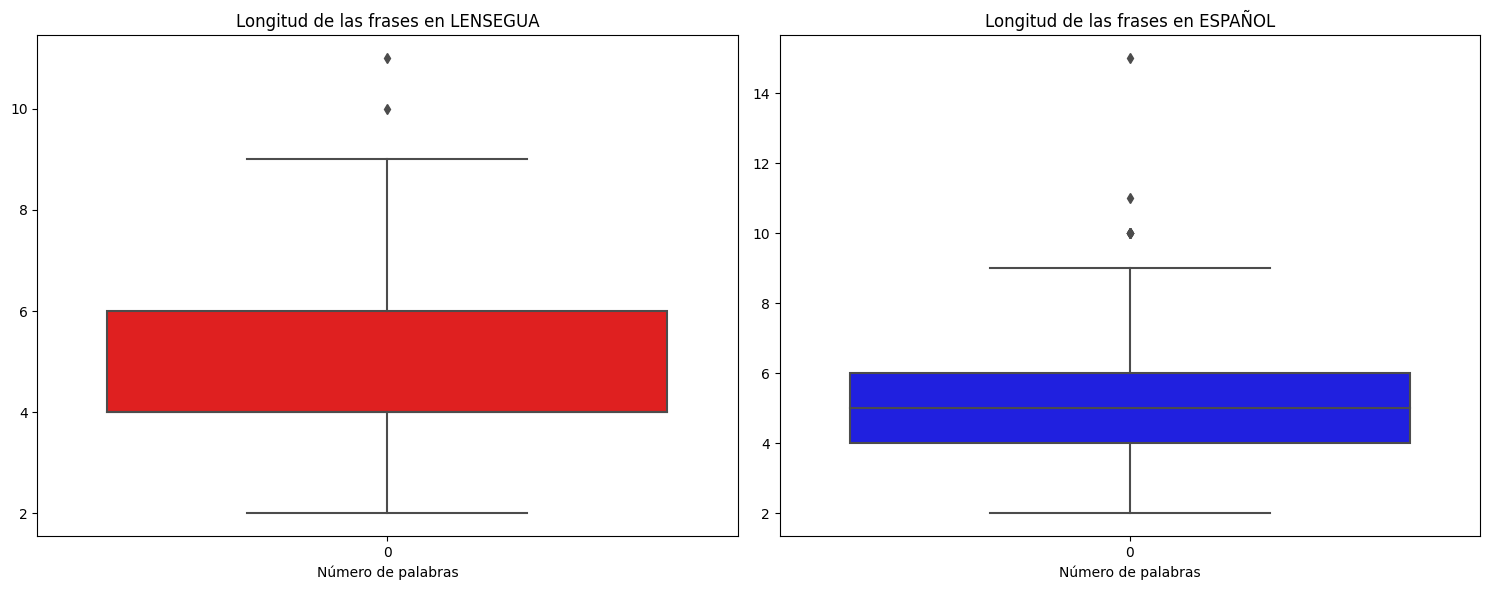

In [3]:
lensegua_len = [len(x.split()) for x in data['LENSEGUA']]       # Get the length of each sentence in LENSEGUA
espanol_len = [len(x.split()) for x in data['ESPAÑOL']]         # Get the length of each sentence in ESPAÑOL

plt.figure(figsize=(15, 6))                             # Create a figure

# 1: LENSEGUA
plt.subplot(1, 2, 1)                                   
sns.boxplot(lensegua_len, color='red')                  
plt.title('Longitud de las frases en LENSEGUA')         # Graph length of sentences in LENSEGUA
plt.xlabel('Número de palabras')

# 2: ESPAÑOL
plt.subplot(1, 2, 2)
sns.boxplot(espanol_len, color='blue')
plt.title('Longitud de las frases en ESPAÑOL')          # Graph length of sentences in ESPAÑOL
plt.xlabel('Número de palabras')

plt.tight_layout()
plt.show()

In [4]:
length_df = pd.DataFrame({          # Create a DataFrame with the length of the sentences
    'LENSEGUA': lensegua_len,
    'ESPAÑOL': espanol_len
})

length_df.describe()                # Display the statistics of the length of the sentences

,LENSEGUA,ESPAÑOL
count,1027.000000,1027.000000
mean,4.721519,4.974684
std,1.391409,1.642913
min,2.000000,2.000000
25%,4.000000,4.000000
50%,4.000000,5.000000
75%,6.000000,6.000000
max,11.000000,15.000000


___

#### *Palabras más comunes en LENSEGUA y ESPAÑOL*

Como cuarto paso, se analizan las palabras más comunes en ambas columnas. 

In [5]:
lensegua_words = ' '.join(data['LENSEGUA']).split()         # Split the sentences in LENSEGUA
espanol_words = ' '.join(data['ESPAÑOL']).split()           # Split the sentences in ESPAÑOL

lensegua_freq = Counter(lensegua_words).most_common(10)     # Get the 10 most common words in LENSEGUA
espanol_freq = Counter(espanol_words).most_common(10)       # Get the 10 most common words in ESPAÑOL

table = PrettyTable()                                       # Create a table
table.field_names = ['LENSEGUA', 'Frecuencia (1)', 'ESPAÑOL', 'Frecuencia (2)'] 

for i in range(10):                                         # Fill the table with the most common words
    table.add_row([lensegua_freq[i][0], lensegua_freq[i][1], espanol_freq[i][0], espanol_freq[i][1]])   # Add a row to the table

print(table)


+----------+----------------+---------+----------------+
| LENSEGUA | Frecuencia (1) | ESPAÑOL | Frecuencia (2) |
+----------+----------------+---------+----------------+
|    tu    |      386       |    la   |      243       |
|    yo    |      342       |    el   |      225       |
| pregunta |      262       |    no   |      207       |
|    no    |      205       |    a    |      133       |
|  pasado  |      165       |    en   |       90       |
|    ir    |      112       |   ayer  |       84       |
|  tener   |       84       |    tu   |       78       |
|   ayer   |       84       |    es   |       75       |
|  futuro  |       68       |    me   |       66       |
|   ella   |       59       |    mi   |       65       |
+----------+----------------+---------+----------------+


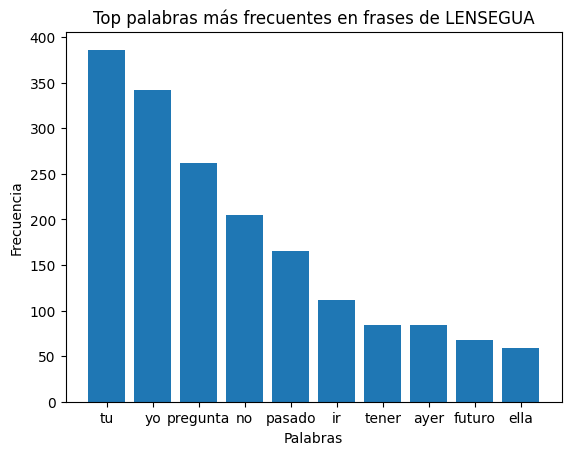

In [6]:
plt.bar(*zip(*lensegua_freq))                               # Create a bar graph with the most common words in LENSEGUA
plt.title('Top palabras más frecuentes en frases de LENSEGUA')
plt.xlabel('Palabras')
plt.ylabel('Frecuencia')
plt.show()

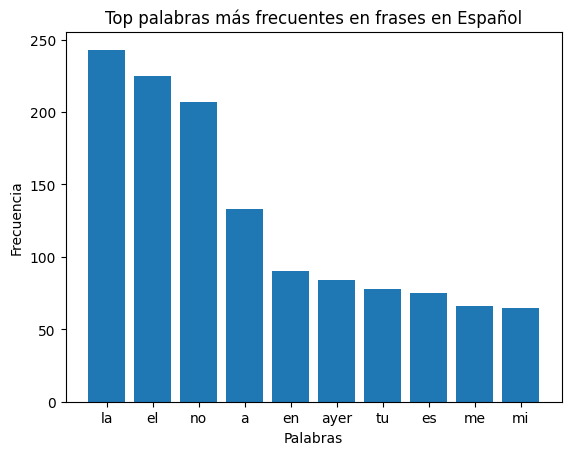

In [7]:
plt.bar(*zip(*espanol_freq))                               # Create a bar graph with the most common words in ESPAÑOL
plt.title('Top palabras más frecuentes en frases en Español')
plt.xlabel('Palabras')
plt.ylabel('Frecuencia')
plt.show()

___

#### *Bigramas más comunes en LENSEGUA y ESPAÑOL*

Finalmente, se analizan los bigramas más comunes en ambas columnas.

In [8]:
# ----------------- GET N-GRAMS ----------------- #
# Function: get_ngrams
# Description: Get the n-grams of a sentence
# Parameters:
#       - text: string with the sentence
#       - n: integer with the number of n-grams to generate
# Return:
#       - list with the n-grams
# ----------------------------------------------- #
def get_ngrams(text, n):
    words = text.split()                                        # Split the sentence into words
    return [' '.join(ngram) for ngram in ngrams(words, n)]      # Get the n-grams

lensegua_bigrams = get_ngrams(' '.join(data['LENSEGUA']), 2)    # Get the bigrams of the sentences in LENSEGUA
espanol_bigrams = get_ngrams(' '.join(data['ESPAÑOL']), 2)      # Get the bigrams of the sentences in ESPAÑOL

lensegua_freq = Counter(lensegua_bigrams).most_common(10)       # Get the 10 most common bigrams in LENSEGUA
espanol_freq = Counter(espanol_bigrams).most_common(10)         # Get the 10 most common bigrams in ESPAÑOL

table = PrettyTable()                                           # Create a table
table.field_names = ['LENSEGUA', 'Frecuencia (1)', 'ESPAÑOL', 'Frecuencia (2)']

for i in range(10):
    table.add_row([lensegua_freq[i][0], lensegua_freq[i][1], espanol_freq[i][0], espanol_freq[i][1]])   # Add a row to the table

print(table)

+----------------+----------------+------------+----------------+
|    LENSEGUA    | Frecuencia (1) |  ESPAÑOL   | Frecuencia (2) |
+----------------+----------------+------------+----------------+
|  pregunta tu   |       97       |    a la    |       56       |
|   pasado yo    |       70       |   en el    |       35       |
| dónde pregunta |       40       |   en la    |       28       |
|   no porque    |       38       |  me gusta  |       24       |
|   no pasado    |       32       | dónde está |       22       |
|     no yo      |       32       |  pero no   |       22       |
|  qué pregunta  |       31       |  gusta el  |       21       |
|     tu ir      |       28       |  la playa  |       20       |
|    ir ayer     |       26       |   no sé    |       20       |
|   gustar no    |       26       | porque no  |       18       |
+----------------+----------------+------------+----------------+


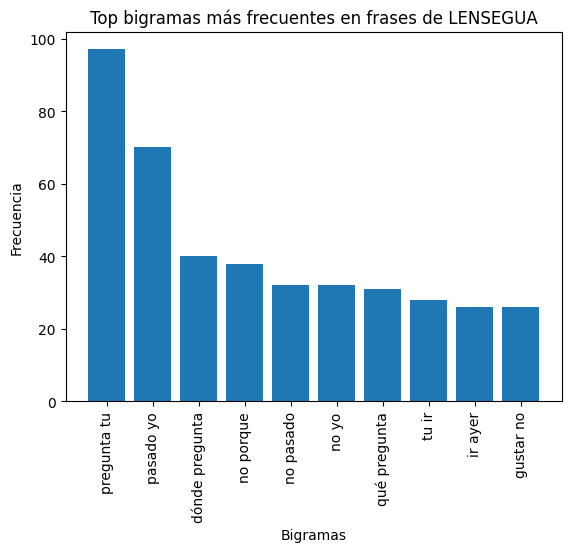

In [9]:
plt.bar(*zip(*lensegua_freq))                                   # Create a bar graph with the most common bigrams in LENSEGUA
plt.title('Top bigramas más frecuentes en frases de LENSEGUA')
plt.xlabel('Bigramas')
plt.ylabel('Frecuencia')
plt.xticks(rotation=90)
plt.show()

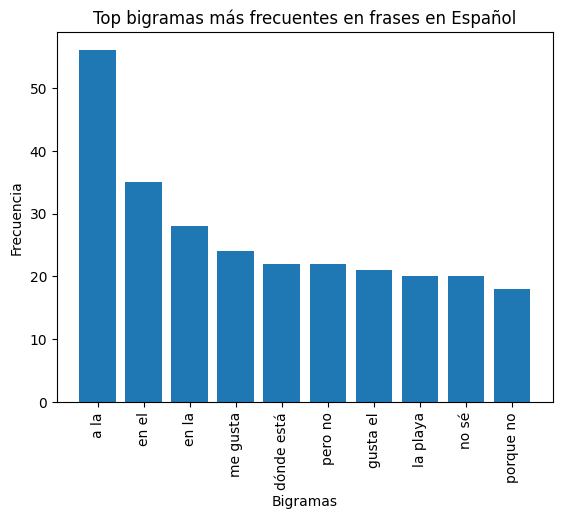

In [10]:
plt.bar(*zip(*espanol_freq))                                   # Create a bar graph with the most common bigrams in ESPAÑOL
plt.title('Top bigramas más frecuentes en frases en Español')
plt.xlabel('Bigramas')
plt.ylabel('Frecuencia')
plt.xticks(rotation=90)
plt.show()